In [1]:
import glob
import json
from typing import List

import pandas as pd
import seaborn as sns

In [2]:
ANNO_DATA_DIR: str = './annotated'
DATA_OUT_PATH: str = './dataset'
OUT_PATH: str = './figures'
RAW_DATA_DIR: str = './finished/main-gpt4' 

In [3]:
#raw_samples = [
#    json.load(open(file, 'r'))
#    for file in glob.glob(f'{ANNO_DATA_DIR}/.json')
#]
raw_samples = []
for filename in glob.glob(ANNO_DATA_DIR + '/*.json'):
    with open(filename, 'r') as f:
        file_data = json.load(f)
        for sample in file_data:
            raw_samples.append(sample)
len(raw_samples)


1038

In [4]:
dataset: pd.DataFrame = (
    pd.json_normalize(raw_samples)
    .set_index('id')    
    .replace({
        'mistralai/Mistral-7B-Instruct-v0.2': 'Mistral-7B-Instruct'
    })
    .replace({
        'gpt-4-turbo-preview': 'GPT-4'
    })

)
#dataset.to_parquet(f'{DATA_OUT_PATH}.full.parquet')

In [5]:
backgroundlist: List[str] = ["affluent-young-woman", "carpenter","environmental-activist","ex-convict", "hustler", "male-college-student", "office-worker", "pensioner", "phd-student", "privileged-woman", "retired-professor", "single-parent", "struggling-artist", "teenager", "unemployed", "wealthy-entrepreneur"]
personaslist: List[str] = ["neutral", "troll", "dystopian", "devilsadvocate", "know-it-all", "mediator", "educator", "karen", "misogynist", "misogynist-dense", "esoteric", "hippie-dense", "hippie", "supportive-saviour-dense", "influencer", "influencer-dense", "social-media-activist-dense", "social-media-activist", "anti", "hobby-expert-dense", "hobby-expert", "narcissist", "sceptic", "shy", "toxic-positive", "traditionalist"]
languagelist: List[str] = ["language-youth", "language-default", "language-old"]
political_viewlist: List[str] = ["conservative", "disengaged", "far-right", "progressive", "radical-left"]
real_tweets: List[str] = [
    ".\u2066@AOC\u2069 is it a \u201ccrime against humanity\u201d when \u2066@POTUS\u2069 secretly flies migrants into Westchester (the place you grew up)? The crime here is allowing the continued flow of illegal immigration, human trafficking and drugs. It has to stop!",
    "Biden\u2019s set on taking away your choice and forcing you to abide by his radical climate agenda. Un-American!",
    "Abortion is health care & should be between a woman & her doctor, not left to politicians like Yvette Herrell who would ban abortion without exceptions for rape, incest or the life of the mother. #NM02",
    "A high school debate team ignores the debate prompt and instead attacks white Christians...and then WINS THE DEBATE: \"We demand that white Christians be held accountable for America's original sin.\" This vile, anti-White racism is rewarded by so-called \"academics.\" We must stop it.",
    "The clean energy revolution is here and we’re going to power it with green union jobs.",
]
def find_language(persona):
    for language in languagelist:
        if language in persona:
            return language
    return None
def find_main_persona(persona):
    for p in personaslist:
        if p in persona:
            return p
    return None
def find_background(persona):
    for background in backgroundlist:
        if background in persona:
            return background
    return None
def find_political_view(persona):
    for political_view in political_viewlist:
        if political_view in persona:
            return political_view
    return None
def find_real_tweets(threads):
    for post in real_tweets:
        if post == threads:
            return True
    return False
dataset['background'] = dataset['persona'].apply(find_background)
dataset['main_persona'] = dataset['persona'].apply(find_main_persona)
dataset['language_prompt'] = dataset['persona'].apply(find_language)
dataset['political_view'] = dataset['persona'].apply(find_political_view)
dataset['real_tweet'] = dataset['threads'].apply(find_real_tweets)

dataset['background'].fillna('None', inplace=True)
dataset['language_prompt'].fillna('None', inplace=True)
dataset['political_view'].fillna('None', inplace=True)
#dataset['main_persona'] = dataset['main_persona'].str.rstrip('dense')
dataset[:1]
#open(f'{DATA_OUT_PATH}.full.json', 'w').write(json.dumps(raw_samples, indent=4, ensure_ascii=False))

,persona,model,original_author,threads,topic,text,payload.id,payload.timestamp,payload.action,payload.persona.id,...,payload.response,annotation.politics,annotation.persona,annotation.tone,annotation.authenticity,background,main_persona,language_prompt,political_view,real_tweet
id,,,,,,,,,,,,,,,,,,,,,
822b4f075c5ec65e2dc04c8ff2aea5af4b2d0bc4a99c9348,teenager_troll_language-youth_radical-left,gpt-3.5-turbo,conservative,Biden’s set on taking away your choice and for...,Environment,"post by @anti_capitalist: oh no, how dare bide...",b1092f08-c67a-11ee-813a-28cfe9139b7b,2024-02-08T13:07:55.354328,reply,teenager_troll_language-youth_radical-left,...,"post by @anti_capitalist: oh no, how dare bide...",5.0,4.0,4.0,4.0,teenager,troll,language-youth,radical-left,True


/tmp/ipykernel_2821/4059511518.py:13: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(y='main_persona', x='annotation.authenticity', hue='model', data=avg, palette=colors, errorbar=None)


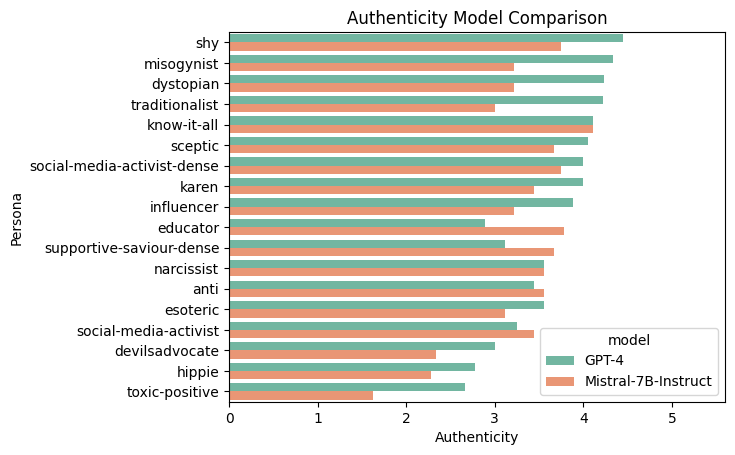

In [6]:
# comparison between mistral and GPT-4 
# compare authenticity between mistral and GPT-4 depending on main_persona
plot_name = 'authenticity_mistralvGPT4_per_persona_bar_chart'

mistral_samples = dataset[dataset['model'] == 'Mistral-7B-Instruct']
gpt4_samples = dataset[(dataset['model'] == 'GPT-4') & (dataset['persona'].isin(mistral_samples['persona']))]
mistral_gpt4_samples = pd.concat([mistral_samples, gpt4_samples])
avg = mistral_gpt4_samples.groupby(['model', 'main_persona'])['annotation.authenticity'].mean().reset_index()
avg = avg.sort_values(by='annotation.authenticity', ascending=False)


colors = sns.color_palette('Set2')
ax = sns.barplot(y='main_persona', x='annotation.authenticity', hue='model', data=avg, palette=colors, errorbar=None)
ax.set_xlim(0, 5.6)  # Set x-axis limit to 5
ax.set_title('Authenticity Model Comparison')
ax.set_ylabel('Persona')
ax.set_xlabel('Authenticity')
sns.move_legend(ax, "lower right")
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

In [7]:
#

display('Base statistics grouped by languages.') 
(
    dataset
    .groupby('model', observed=False)
    .describe(percentiles=[])
    .loc[:, (slice(None), ['mean', 'std'])]
    .T
    #.reindex(columns=LANG_ORDER)
)
display('Sample size per persona:')
dataset.groupby('main_persona').size()


'Base statistics grouped by languages.'

'Sample size per persona:'

main_persona
anti                           63
devilsadvocate                 63
dystopian                      63
educator                       36
esoteric                       36
hippie                         27
hippie-dense                    9
hobby-expert                    9
hobby-expert-dense             18
influencer                     36
karen                          36
know-it-all                    45
mediator                       27
misogynist                     90
narcissist                     36
neutral                        63
sceptic                        63
shy                            54
social-media-activist          18
social-media-activist-dense    27
supportive-saviour-dense       27
toxic-positive                 36
traditionalist                 54
troll                          48
dtype: int64

In [8]:
#authenticity bar chart per persona
"""
colors = sns.color_palette('Set2')

ax = (
    dataset
    .groupby('main_persona', observed=False)
    .describe(percentiles=[])
    .loc[:, ('annotation.authenticity', ['mean'])]
    .T
    .plot(kind='bar', width=5, color=colors)  
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add dashed line at value 3.0 on y-axis
ax.axhline(y=3.0, color=(0.2, 0.2, 0.2), linestyle='--')
"""

"\ncolors = sns.color_palette('Set2')\n\nax = (\n    dataset\n    .groupby('main_persona', observed=False)\n    .describe(percentiles=[])\n    .loc[:, ('annotation.authenticity', ['mean'])]\n    .T\n    .plot(kind='bar', width=5, color=colors)  \n)\n\nax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')\nax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')\n\n# Add dashed line at value 3.0 on y-axis\nax.axhline(y=3.0, color=(0.2, 0.2, 0.2), linestyle='--')\n"

/tmp/ipykernel_2821/3979663664.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='annotation.authenticity', y='main_persona', data=avg_authenticity, palette=colors)
/tmp/ipykernel_2821/3979663664.py:6: UserWarning: 
The palette list has fewer values (8) than needed (24) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='annotation.authenticity', y='main_persona', data=avg_authenticity, palette=colors)


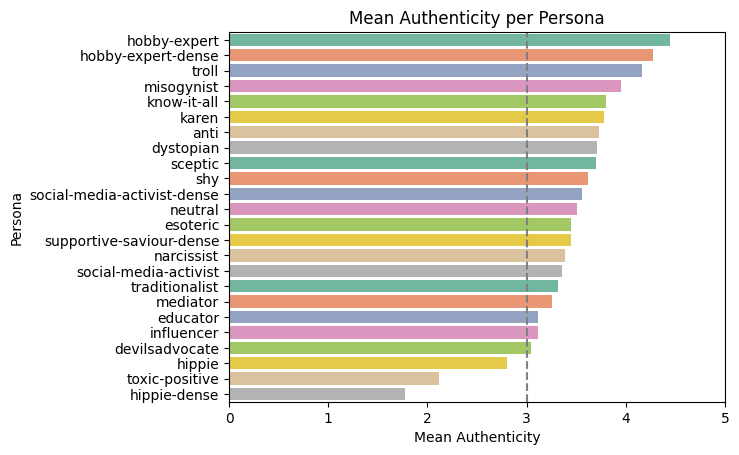

In [9]:

# Calculate the average of annotation.authenticity per main_persona
plot_name = 'authenticity_per_persona_bar_chart'
avg_authenticity = dataset.groupby('main_persona')['annotation.authenticity'].mean().reset_index()
avg_authenticity = avg_authenticity.sort_values(by='annotation.authenticity', ascending=False)
colors = sns.color_palette('Set2')
ax = sns.barplot(x='annotation.authenticity', y='main_persona', data=avg_authenticity, palette=colors)
ax.set_xlim(0, 5)  # Set x-axis limit to 5
ax.set_xlabel('Mean Authenticity')
ax.set_ylabel('Persona')
ax.set_title('Mean Authenticity per Persona')

# Add dashed line at authenticity 3.0
ax.axvline(x=3.0, color='grey', linestyle='--')

ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

/tmp/ipykernel_2821/401325601.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='annotation.tone', y='main_persona', data=avg, palette=colors)
/tmp/ipykernel_2821/401325601.py:6: UserWarning: 
The palette list has fewer values (8) than needed (24) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='annotation.tone', y='main_persona', data=avg, palette=colors)


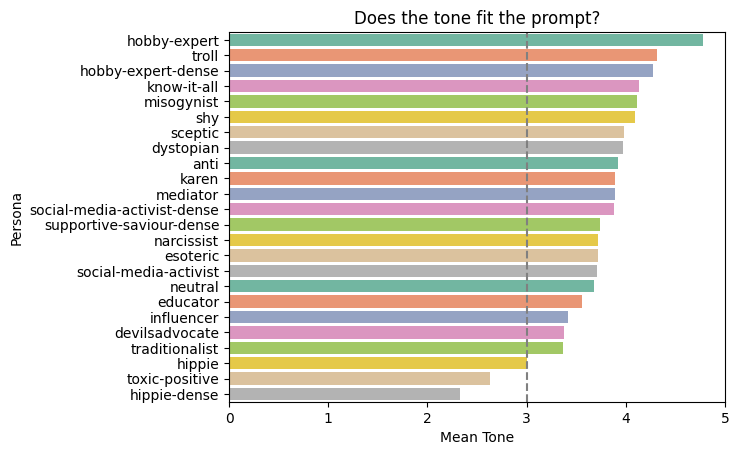

In [10]:

# Calculate the average of annotation.tone per main_persona
plot_name = 'tone_per_persona_bar_chart'
avg = dataset.groupby('main_persona')['annotation.tone'].mean().reset_index()
avg = avg.sort_values(by='annotation.tone', ascending=False)
colors = sns.color_palette('Set2')
ax = sns.barplot(x='annotation.tone', y='main_persona', data=avg, palette=colors)
ax.set_xlim(0, 5)  # Set x-axis limit to 5
ax.set_xlabel('Mean Tone')
ax.set_ylabel('Persona')
ax.set_title('Does the tone fit the prompt?')

# Add dashed line at authenticity 3.0
ax.axvline(x=3.0, color='grey', linestyle='--')

ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

/tmp/ipykernel_2821/1691169666.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='annotation.politics', y='main_persona', data=avg, palette=colors)
/tmp/ipykernel_2821/1691169666.py:6: UserWarning: 
The palette list has fewer values (8) than needed (24) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='annotation.politics', y='main_persona', data=avg, palette=colors)


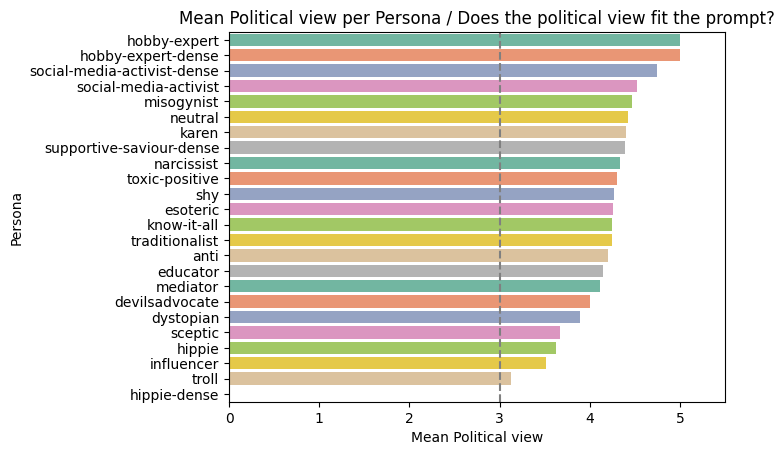

In [11]:
# Calculate the average of annotation.politics per main_persona
plot_name = 'anno.politics_per_persona_bar_chart'
avg = dataset.groupby('main_persona')['annotation.politics'].mean().reset_index()
avg = avg.sort_values(by='annotation.politics', ascending=False)
colors = sns.color_palette('Set2')
ax = sns.barplot(x='annotation.politics', y='main_persona', data=avg, palette=colors)
ax.set_xlim(0, 5.5)  # Set x-axis limit to 5
ax.set_xlabel('Mean Political view')
ax.set_ylabel('Persona')
ax.set_title('Mean Political view per Persona / Does the political view fit the prompt?')


# Add dashed line at authenticity 3.0
ax.axvline(x=3.0, color='grey', linestyle='--')

ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

/tmp/ipykernel_2821/3484049030.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='annotation.persona', y='main_persona', data=avg, palette=colors)
/tmp/ipykernel_2821/3484049030.py:6: UserWarning: 
The palette list has fewer values (8) than needed (24) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='annotation.persona', y='main_persona', data=avg, palette=colors)


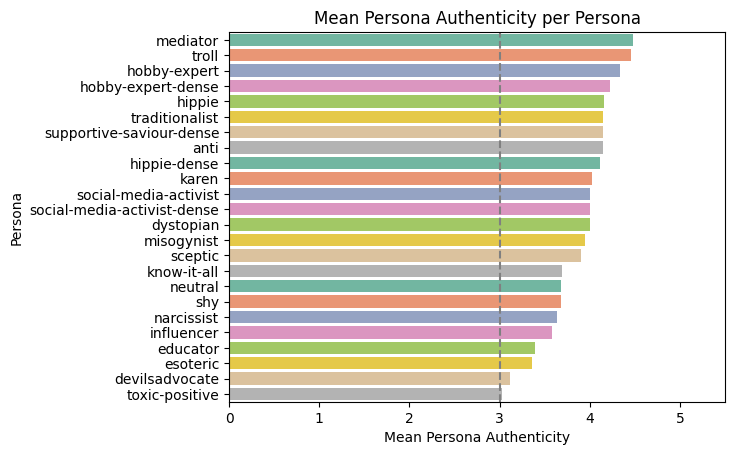

In [12]:

# Calculate the average of annotation.persona per main_persona
plot_name = 'anno.persona_per_persona_bar_chart'
avg = dataset.groupby('main_persona')['annotation.persona'].mean().reset_index()
avg = avg.sort_values(by='annotation.persona', ascending=False)
colors = sns.color_palette('Set2')
ax = sns.barplot(x='annotation.persona', y='main_persona', data=avg, palette=colors)
ax.set_xlim(0, 5.5)  # Set x-axis limit to 5
ax.set_xlabel('Mean Persona Authenticity')
ax.set_ylabel('Persona')
ax.set_title('Mean Persona Authenticity per Persona')

# Add dashed line at authenticity 3.0
ax.axvline(x=3.0, color='grey', linestyle='--')

ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

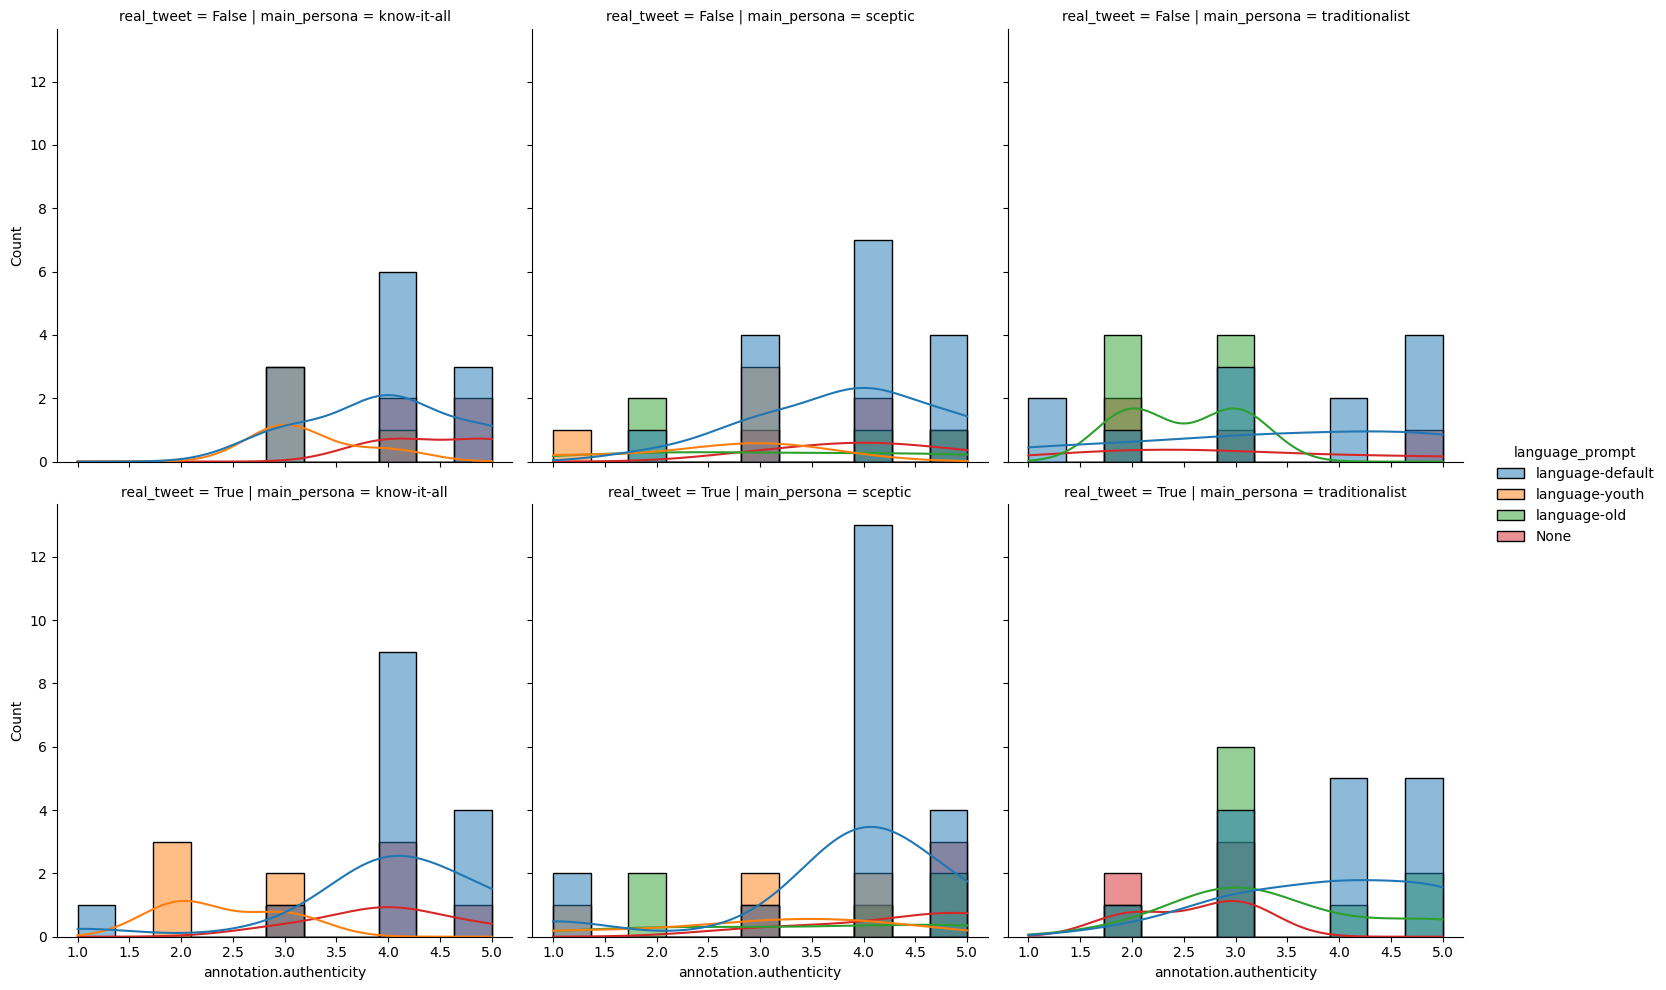

In [13]:
plot_name = 'displot'
selected_dataset = dataset[dataset['main_persona'].isin(['sceptic', 'traditionalist', 'know-it-all'])]
ax = sns.displot(
    selected_dataset, 
    x="annotation.authenticity", 
    col="main_persona", 
    row="real_tweet", 
    hue="language_prompt", 
    kde=True,
    #row_order=LANG_ORDER,
)
#ax.savefig(f'{OUT_PATH}/dist.persona.png', format="png", bbox_inches="tight") 

/tmp/ipykernel_2821/586227146.py:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(y='language_prompt', x='annotation.authenticity', hue='real_tweet', data=dataset, palette=colors, errorbar=None)


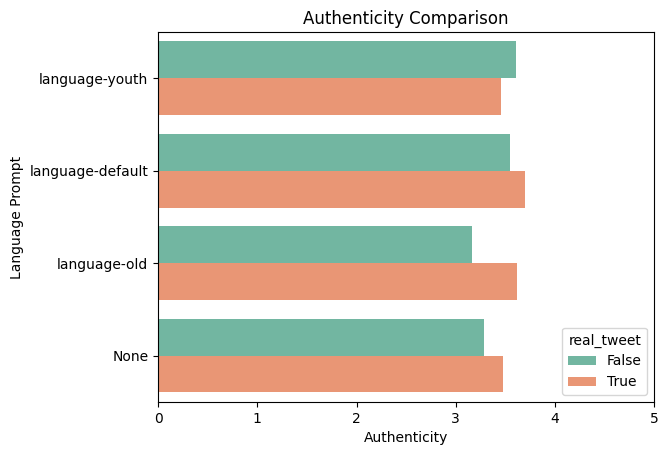

In [14]:
# compare authenticity between real and generated tweets depending on language prompt
plot_name = 'authenticity_realvfake_per_language_bar_chart'
colors = sns.color_palette('Set2')
ax = sns.barplot(y='language_prompt', x='annotation.authenticity', hue='real_tweet', data=dataset, palette=colors, errorbar=None)
ax.set_xlim(0, 5)  # Set x-axis limit to 5
ax.set_title('Authenticity Comparison')
ax.set_ylabel('Language Prompt')
ax.set_xlabel('Authenticity')
sns.move_legend(ax, "lower right")
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

/tmp/ipykernel_2821/3426142583.py:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(y='language_prompt', x='annotation.tone', hue='real_tweet', data=dataset, palette=colors, errorbar=None)


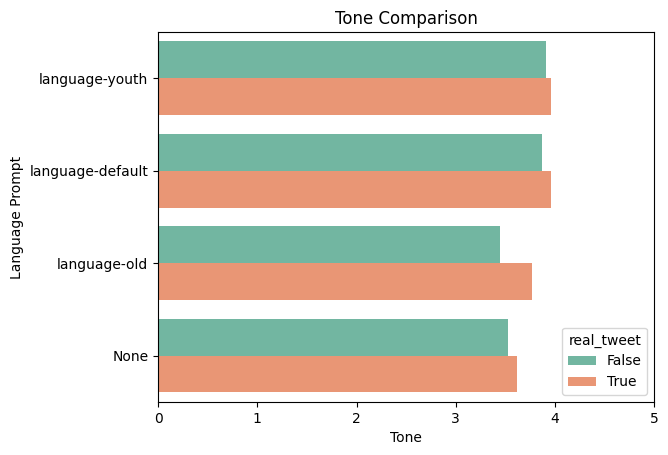

In [15]:
# compare tone between real and fake tweets depending on language prompt
plot_name = 'tone_realvfake_per_language_bar_chart'
colors = sns.color_palette('Set2')
ax = sns.barplot(y='language_prompt', x='annotation.tone', hue='real_tweet', data=dataset, palette=colors, errorbar=None)
ax.set_xlim(0, 5)  # Set x-axis limit to 5
ax.set_title('Tone Comparison')
ax.set_xlabel('Tone')
ax.set_ylabel('Language Prompt')
sns.move_legend(ax, "lower right")
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

/tmp/ipykernel_2821/3299040966.py:8: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  ax = sns.barplot(y='main_persona', x='annotation.tone', hue='with_language_prompt', data=dataset, palette=colors, errorbar=None)


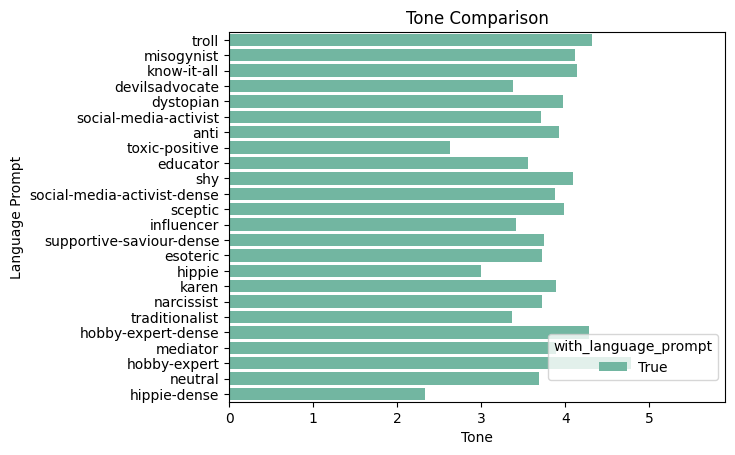

In [16]:
# compare tone between language prompt and no language prompt depending on language prompt
plot_name = 'tone_per_persona_language_yesvno_bar_chart'
colors = sns.color_palette('Set2')

# Filter the dataset to include only the rows with language prompts
dataset['with_language_prompt'] = dataset['language_prompt'].notnull()
# Plot the tone comparison without error bars
ax = sns.barplot(y='main_persona', x='annotation.tone', hue='with_language_prompt', data=dataset, palette=colors, errorbar=None)
ax.set_xlim(0, 5.9)  # Set x-axis limit to 5
ax.set_title('Tone Comparison')
ax.set_xlabel('Tone')
ax.set_ylabel('Language Prompt')
sns.move_legend(ax, "lower right", bbox_to_anchor=(1.0, 0.04))
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

/tmp/ipykernel_2821/1720191056.py:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(y='political_view', x='annotation.politics', hue='real_tweet', data=dataset[dataset['political_view'] != 'None'], palette=colors, errorbar=None)


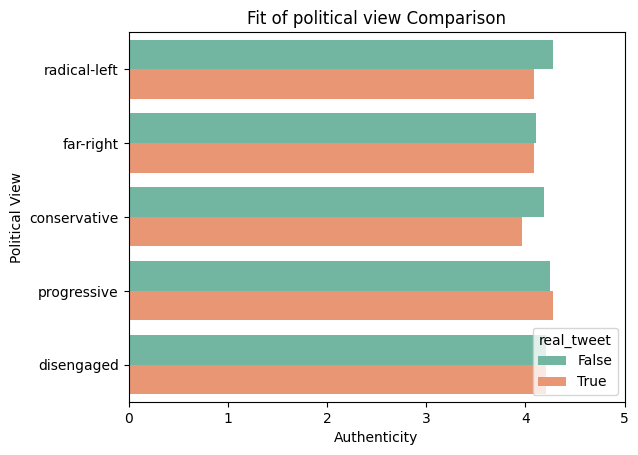

In [17]:
# compare fit of political opinion between real and generated tweets depending on political view
plot_name = 'political_view_fit_realvfake_bar_chart'
colors = sns.color_palette('Set2')
ax = sns.barplot(y='political_view', x='annotation.politics', hue='real_tweet', data=dataset[dataset['political_view'] != 'None'], palette=colors, errorbar=None)
ax.set_xlim(0, 5)  # Set x-axis limit to 5
ax.set_title('Fit of political view Comparison')
ax.set_ylabel('Political View')
ax.set_xlabel('Authenticity')
sns.move_legend(ax, "lower right")
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

/tmp/ipykernel_2821/1797211006.py:5: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(x='annotation.authenticity', y='political_view', hue='real_tweet', data=dataset, palette=colors, errorbar=None)


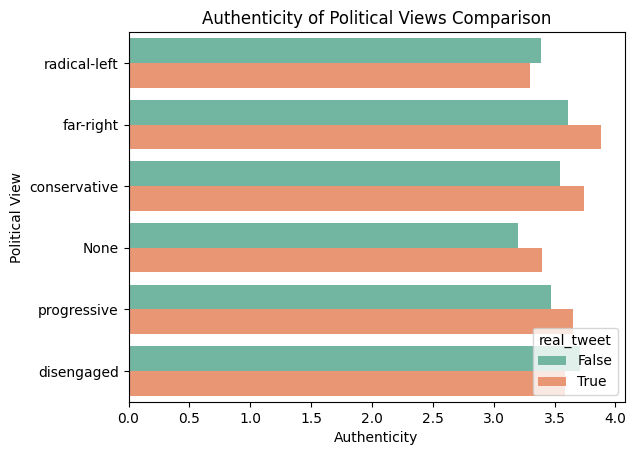

In [18]:
# compare authenticity of political opinion between real and generated tweets depending on political view
ax.set_xlim(0, 5)  # Set x-axis limit to 5
plot_name = 'authenticity_realvfake_per_political_view_bar_chart'
colors = sns.color_palette('Set2')
ax = sns.barplot(x='annotation.authenticity', y='political_view', hue='real_tweet', data=dataset, palette=colors, errorbar=None)
ax.set_title('Authenticity of Political Views Comparison')
ax.set_ylabel('Political View')
ax.set_xlabel('Authenticity')
sns.move_legend(ax, "lower right")
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

In [19]:
# real vs fake tweets
"""
plot_name = 'realvfake_per_persona_bar_chart'
sample_personas = ["troll", "devilsadvocate", "know-it-all"]
ax = sns.violinplot(
    data=dataset,
    x="sample_personas",
    y="annotation.authenticity",
    hue="real_tweet",
    inner="quart",
    split=True,
    #order=[TWEET_ORDER],
    cut=0
)
sns.move_legend(ax, "lower right")
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")
"""

'\nplot_name = \'realvfake_per_persona_bar_chart\'\nsample_personas = ["troll", "devilsadvocate", "know-it-all"]\nax = sns.violinplot(\n    data=dataset,\n    x="sample_personas",\n    y="annotation.authenticity",\n    hue="real_tweet",\n    inner="quart",\n    split=True,\n    #order=[TWEET_ORDER],\n    cut=0\n)\nsns.move_legend(ax, "lower right")\nax.get_figure().savefig(f\'{OUT_PATH}/{plot_name}.png\', format="png", bbox_inches="tight")\n'